<a href="https://colab.research.google.com/github/FabianoMahler/hello-world/blob/master/cleveland_cvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install dfply ## instala o pacote DFPLY
!pip install scikit-plot ## instala o pacote SCIKIT-PLOT
!pip install xgboost
!pip install graphviz
##!pip install python-graphviz

!pip install dtreeviz
!pip install pandas-profiling

In [0]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

### biblioteca SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import random

from dfply import *

import scikitplot as skplt

from dtreeviz.trees import *

import pandas_profiling


import warnings
warnings.filterwarnings("ignore")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df=pd.read_csv('gdrive/My Drive/cleveland.csv')


In [0]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,binaryClass
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,P
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,N
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,N
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,P
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,P
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,P
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,N
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,P
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,N
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,N


In [0]:
profile = pandas_profiling.ProfileReport(df)
profile

Number of variables,14
Number of observations,303
Total Missing (%),0.0%
Total size in memory,33.3 KiB
Average record size in memory,112.4 B
Numeric,8
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


In [0]:
df_cvd = (df >>
               drop(X.ca, X.thal, X.thalach)
              )

In [0]:
df_cvd.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,exang,oldpeak,slope,binaryClass
0,63,1,1,145,233,1,2,0,2.3,3,P
1,67,1,4,160,286,0,2,1,1.5,2,N
2,67,1,4,120,229,0,2,1,2.6,2,N
3,37,1,3,130,250,0,0,0,3.5,3,P
4,41,0,2,130,204,0,2,0,1.4,1,P


In [0]:
df_cvd.dtypes

age              int64
sex              int64
cp               int64
trestbps         int64
chol             int64
fbs              int64
restecg          int64
exang            int64
oldpeak        float64
slope            int64
binaryClass     object
dtype: object

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_cvd.drop(['binaryClass'], axis=1)
y = df_cvd['binaryClass']
X = StandardScaler().fit_transform(X)
y = LabelEncoder().fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
df_cvd.head()


,age,sex,cp,trestbps,chol,fbs,restecg,exang,oldpeak,slope,binaryClass
0,63,1,1,145,233,1,2,0,2.3,3,P
1,67,1,4,160,286,0,2,1,1.5,2,N
2,67,1,4,120,229,0,2,1,2.6,2,N
3,37,1,3,130,250,0,0,0,3.5,3,P
4,41,0,2,130,204,0,2,0,1.4,1,P


In [0]:
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1. 

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))
               
    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
        
    if plot_calibration:
      
      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')
      
      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)
      
      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
        
      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
      
      plt.tight_layout()
      plt.show()
    
    
    

In [0]:
help(runModel)

Help on function runModel in module __main__:

runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title='', pos_label=1)
    Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr = LogisticRegression()

Regressão Logística:
	Brier: 0.130
	Precision: 0.807
	Recall: 0.902
	F1: 0.852



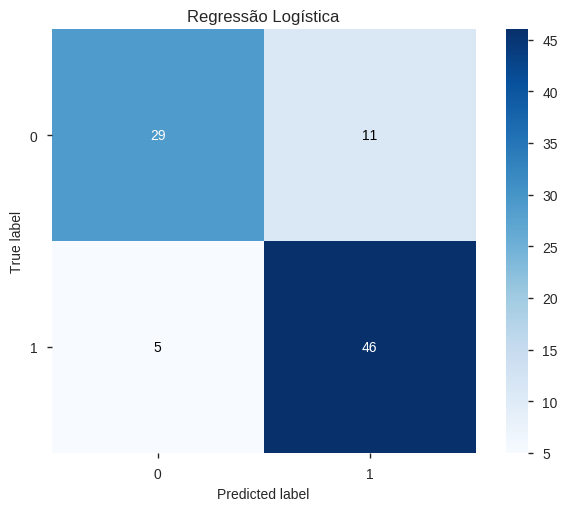

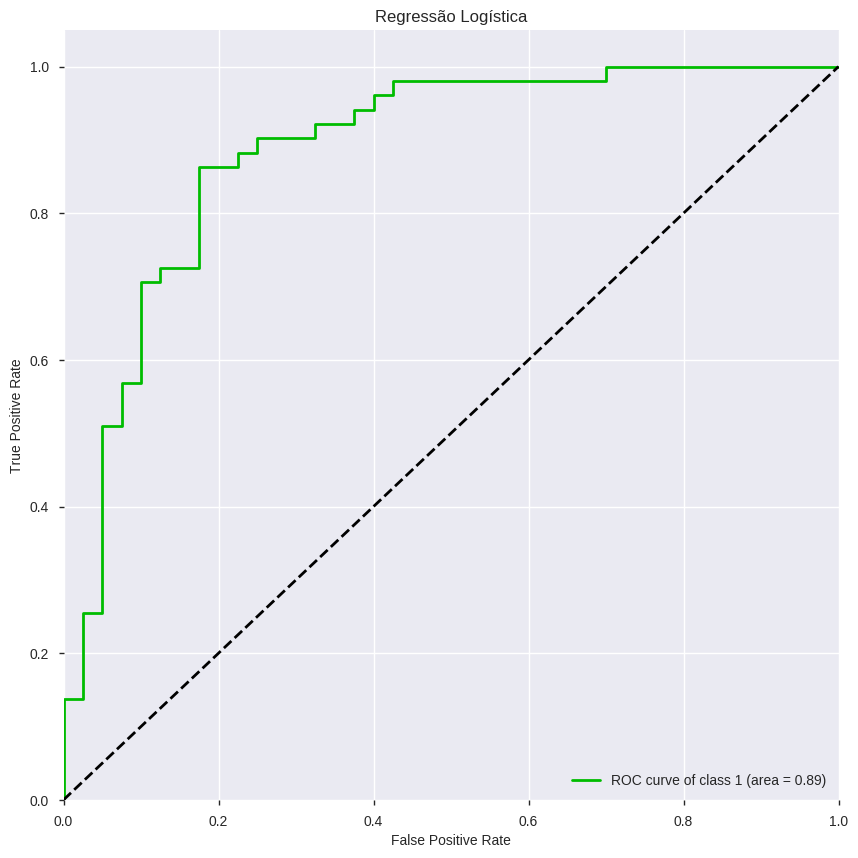

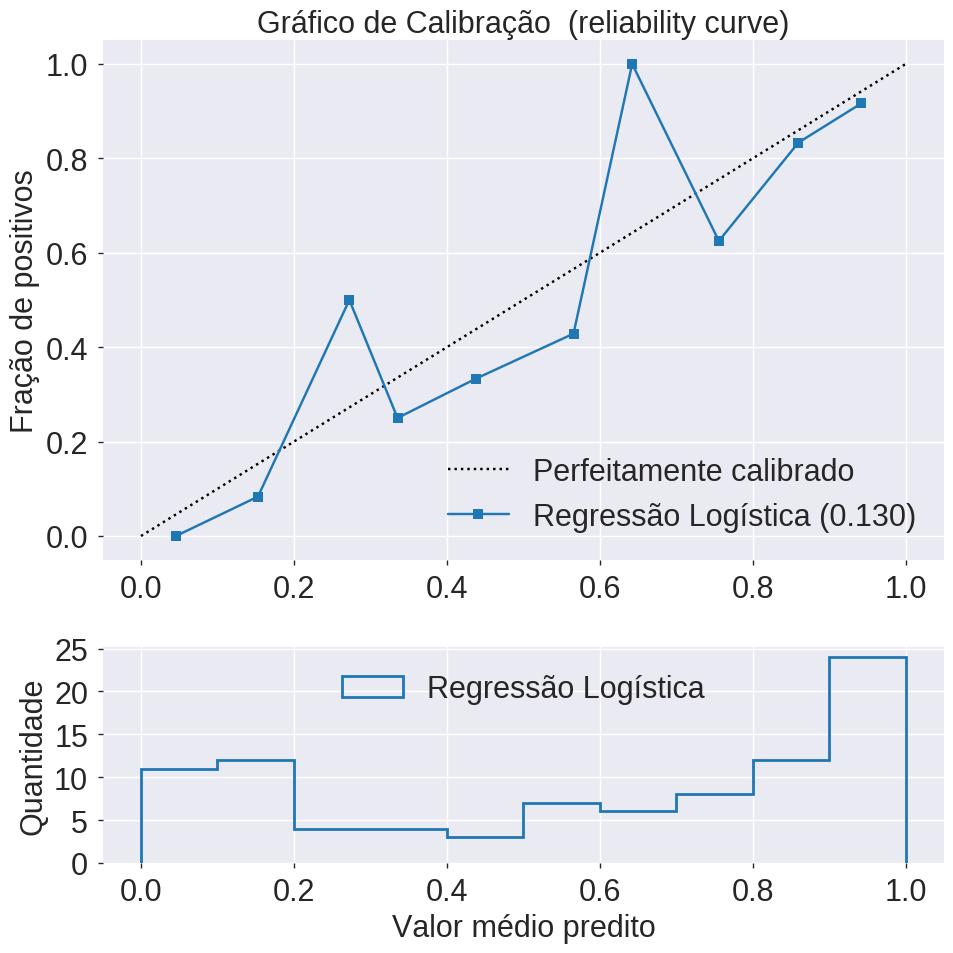

In [0]:
runModel(lr, X_train, y_train, X_test, y_test, title="Regressão Logística")

In [0]:
# criando a random forest

fit_rf = RandomForestClassifier(random_state=42, verbose=1)



In [0]:
np.random.seed(42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Caso deseje rodar GridSearchCV, troque a linha acima pela que segue

cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,
                     n_jobs = -1) 

cv_rf = RandomizedSearchCV(fit_rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,
                     n_jobs = -1)



In [0]:
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
rf = cv_rf.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest:
	Brier: 0.138
	Precision: 0.770
	Recall: 0.922
	F1: 0.839



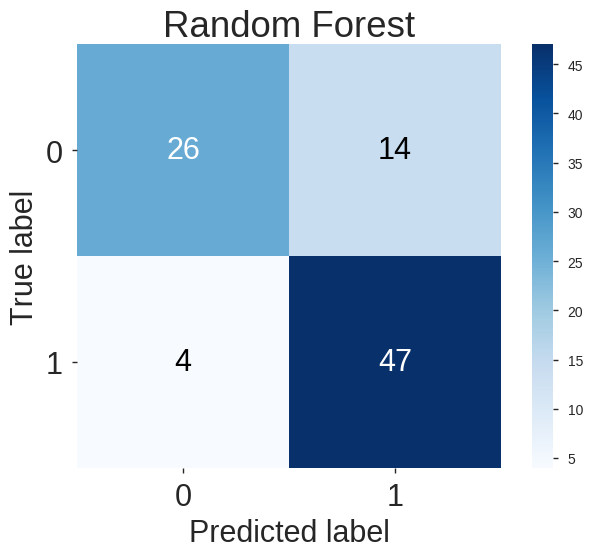

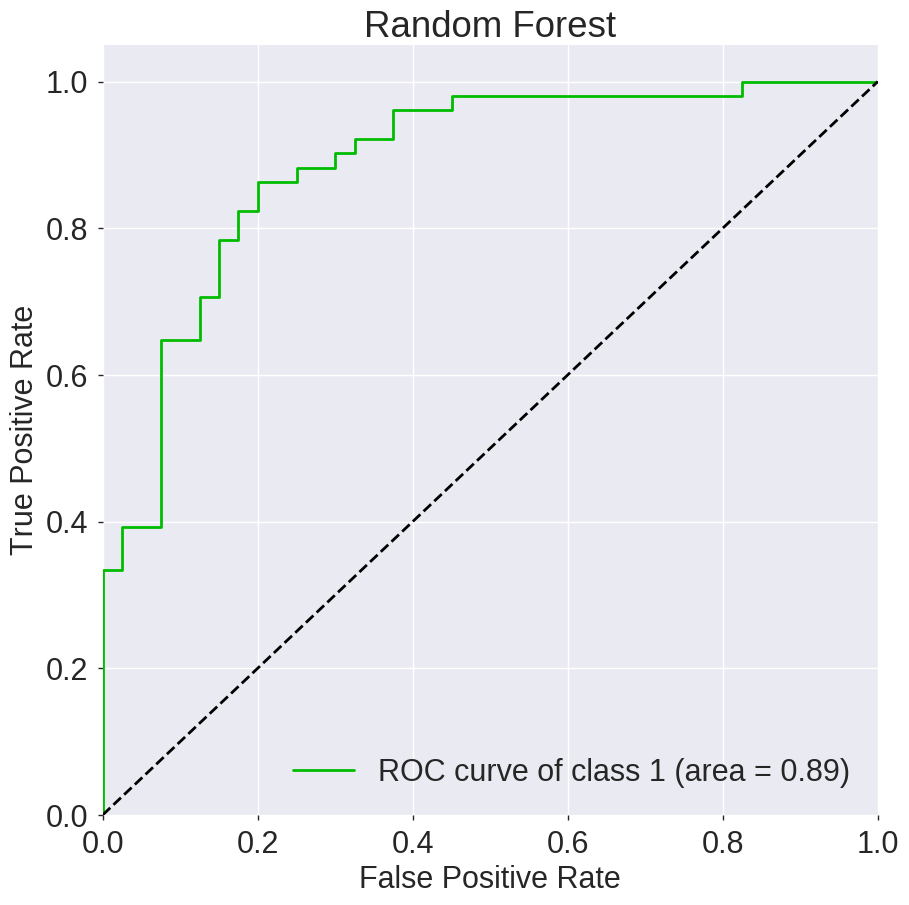

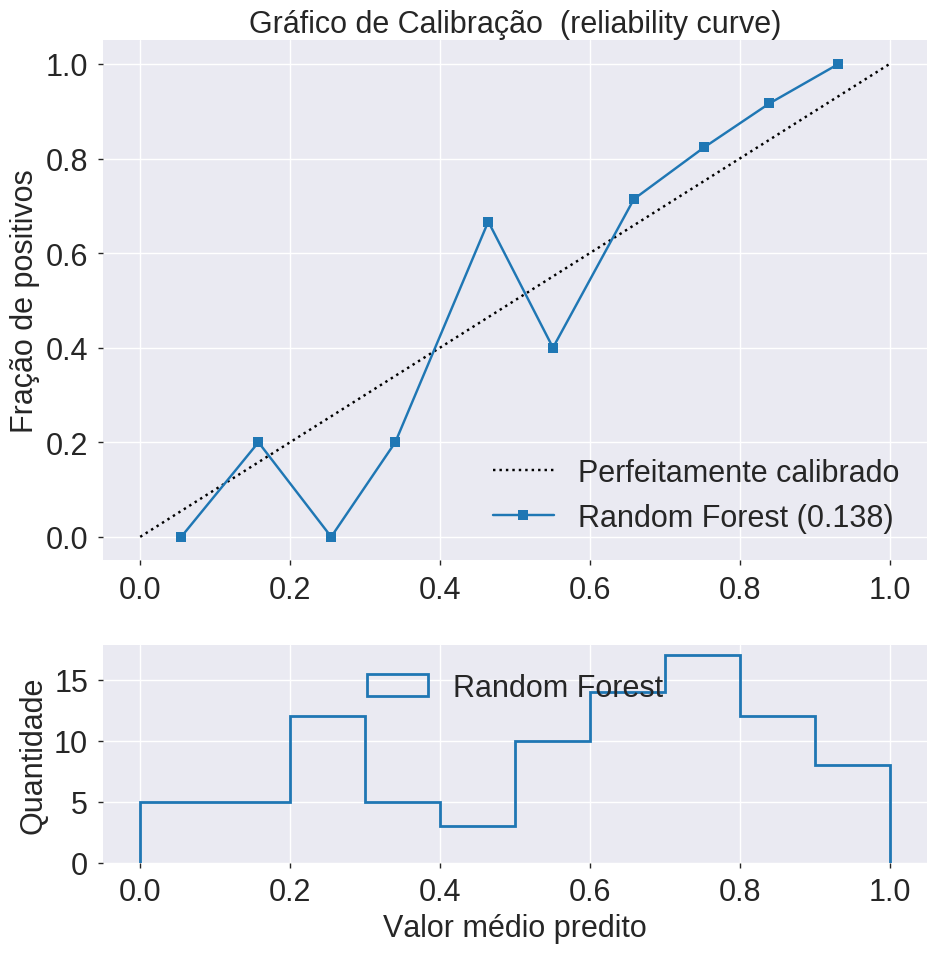

In [0]:
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")

In [0]:
df_cvd.shape

(303, 11)

In [0]:
from sklearn import neural_network

In [0]:
rna = neural_network.MLPClassifier(activation='tanh', alpha=0.1, batch_size=5, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

RNA:
	Brier: 0.225
	Precision: 0.769
	Recall: 0.784
	F1: 0.777



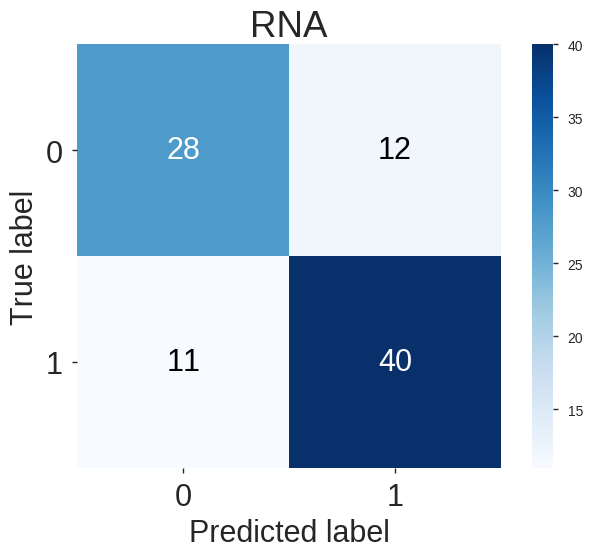

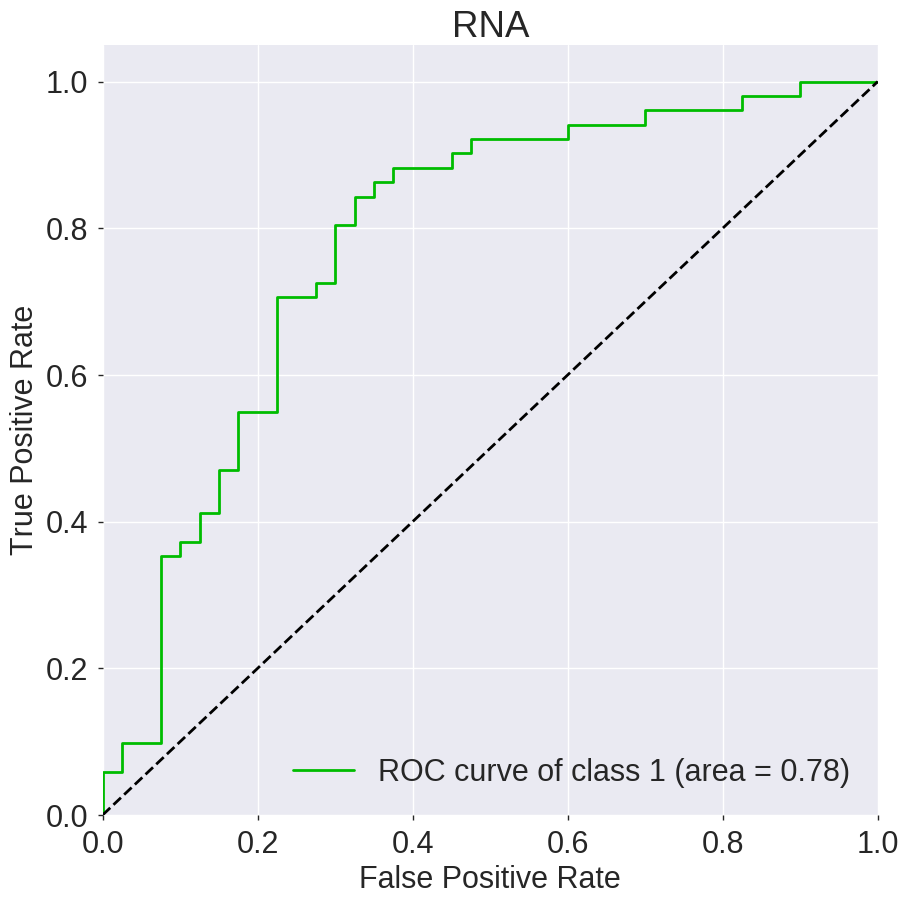

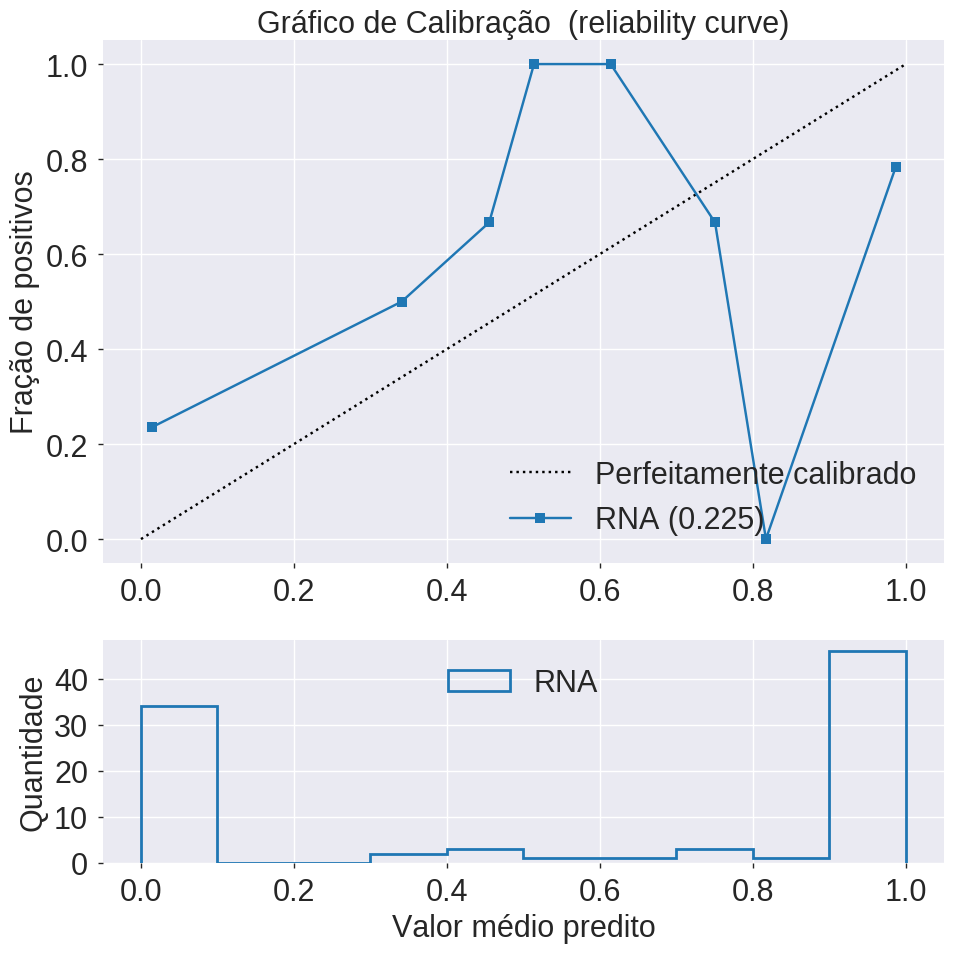

In [0]:
runModel(rna, X_train, y_train, X_test, y_test, title="RNA")